In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm

device = torch.device("cuda")

In [8]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
x_trainval, x_test,y_trainval,y_test = train_test_split(df['text'], df['label'],random_state=2020, test_size=0.2, stratify=df['label'])


x_train, x_val, y_train, y_val = train_test_split(x_trainval,y_trainval, random_state=2020, test_size=0.25, stratify=y_trainval)

In [10]:
bert = AutoModel.from_pretrained('bert-base-uncased');
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased');
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
sent_id = tokenizer.batch_encode_plus(text, padding=True)
print(sent_id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


count    4457.000000
mean       15.565851
std        11.327951
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       162.000000
dtype: float64

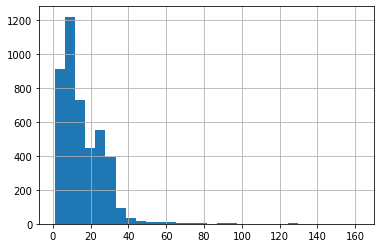

In [11]:
sentence_length = [len(i.split()) for i in x_trainval]
pd.Series(sentence_length).hist(bins = 30)
pd.Series(sentence_length).describe()

#75% sentence have length of 23.Hence assigning max=length=23

In [12]:
tokens_train = tokenizer.batch_encode_plus(x_train.tolist(),max_length = 23,padding='max_length',truncation=True)
tokens_val   = tokenizer.batch_encode_plus(x_val.tolist()  ,max_length = 23,padding='max_length',truncation=True)
tokens_test  = tokenizer.batch_encode_plus(x_test.tolist() ,max_length = 23,padding='max_length',truncation=True)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [13]:
batch_size = 32

train = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train)
train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)

val = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val)
val_dataloader = DataLoader(val, sampler = val_sampler, batch_size=batch_size)

In [14]:
for param in bert.parameters():
    param.requires_grad = False


class BERT_custom(nn.Module):

    def __init__(self, bert):
      
      super(BERT_custom, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, sent_id, mask):

      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x

In [15]:
model = BERT_custom(bert)
model = model.to(device)

BERT_custom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [44]:
optimizer = AdamW(model.parameters(),lr = 1e-5) 
cross_entropy  = nn.NLLLoss()
epochs = 10

best_valid_loss = float('inf')


train_losses=[]
valid_losses=[]
valid_accuracy=[]
tk=tqdm(range(epochs), total = epochs,desc="Epochs", position = 0, leave = True)
for epoch in tk:

    # print('Epoch {}/{}'.format(epoch, epochs - 1))
    # print('-' * 10)
    model.train()
    train_loss = []
    counter = 0
    
    for step,batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        sent_id, mask, labels = batch
        
        model.zero_grad()
        outputs = model(sent_id, mask)
        loss = cross_entropy(outputs, labels)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()  

        train_loss.append(loss.item())
        counter += 1



    mean_train_loss = np.mean(train_loss)


    model.eval()
    val_loss=[]
    val_accuracy=[]
    for step,batch in enumerate(val_dataloader):

      # print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

      batch = tuple(t.to(device) for t in batch)
      sent_id, mask, labels = batch

      with torch.no_grad():

        outputs = model(sent_id, mask)

        loss = cross_entropy(outputs,labels)
        val_loss.append(loss.item())

        val_accuracy.append(np.mean(np.equal(np.argmax(outputs.detach().cpu().numpy(),axis=1),labels.detach().cpu().numpy())))

    mean_valid_loss = np.mean(val_loss)
    mean_valid_acc  = np.mean(val_accuracy)

    tk.set_postfix({'Training Loss': mean_train_loss,'Validation Loss': mean_valid_loss,'Validation Accuracy': mean_valid_acc*100})
    tk.update()

    #save the best model
    if mean_valid_loss < best_valid_loss:
        best_valid_loss = mean_valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(mean_train_loss)
    valid_losses.append(mean_valid_loss)
    valid_accuracy.append(mean_valid_acc)

    
print(f'\nTraining Loss: {np.mean(train_losses):.3f}')
print(f'Validation Loss: {np.mean(valid_losses):.3f}')
print(f'Validation Accuracy: {np.mean(valid_accuracy):.3f}')

Epochs: 100%|██████████| 10/10 [01:16<00:00,  7.67s/it, Training Loss=0.172, Validation Loss=0.173, Validation Accuracy=0.94]


Training Loss: 0.182
Validation Loss: 0.182
Validation Accuracy: 0.935


In [45]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       966
           1       0.94      0.64      0.76       149

    accuracy                           0.95      1115
   macro avg       0.94      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115

